在 Keras 架構下以 ResNet-50 預訓練模型為基礎，建立可用來辨識狗與貓，並在雲端上執行

# 準備資料及設定環境

## 設定環境

In [1]:
# 查看 GPU
!nvidia-smi

Wed May 25 15:24:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# 設定連結 Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 準備資料

### 下載資料集和預訓練模型 (雲端需執行，Google Drive不需重複執行)

In [3]:
from IPython.display import clear_output
!git clone https://github.com/AI-FREE-Team/Kaggle_dog-and-cat.git
!apt-get install unrar
!unrar x '/content/Kaggle_dog-and-cat/cat_dog_classifier.part01.rar'
clear_output(wait=True)
print('下載完成!')

下載完成!


### 解壓縮資料

#### 雲端上執行 (需重複執行)

In [4]:
import zipfile
zip_files = ['train.zip', 'test1.zip']

for zip_file in zip_files:
    with zipfile.ZipFile("/content/{}".format(zip_file),"r") as z:
        z.extractall("/content/")
        print("{} unzipped".format(zip_file))

train.zip unzipped
test1.zip unzipped


#### Google Drive 上執行 (不需重複執行)

In [ ]:
import os
print( f'預設的工作資料夾：{os.getcwd()}' )
# 指定 Google Drive 中的工作資料夾
os.chdir( '/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/Input/' )
retval = os.getcwd()
print( f'指定的工作資料夾：{retval}' )

預設的工作資料夾：/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/Input
指定的工作資料夾：/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/Input


In [ ]:
import shutil
#Copy a file to other Directory
Path = shutil.copy('/content/train.zip', '/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/Input/')
#Copy a file with new name
newPath = shutil.copy('/content/test1.zip', '/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/Input/test.zip')

In [ ]:
import zipfile
zip_files = ['train.zip', 'test.zip']

for zip_file in zip_files:
    with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/Input/{}'.format(zip_file), 'r') as z:
        z.extractall('/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/Input/')
        print('{} unzipped'.format(zip_file))

train.zip unzipped


# Import Package

In [5]:
!pip install tensorflow==2.1.0
# 要按restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 421.8 MB 25 kB/s 
     |████████████████████████████████| 448 kB 62.2 MB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
     |████████████████████████████████| 3.8 MB 53.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=99dc60f0889867c264d76c7922a72deeee9c4174ac0ab8d24618d6e9f2c40653
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [6]:
try :
  %tensorflow_version 2.x
except Exception :
  pass
import tensorflow as tf

In [7]:
try:
    from PIL import Image
except ImportError:
    import Image

In [8]:
from platform import python_version

In [9]:
import numpy as np      # linear algebra
import pandas as pd     # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os

import warnings

warnings.filterwarnings('ignore')

In [10]:
# 確認 Python 的版本
print( 'Python Version：', python_version() )
# 確認 tensorflow 的版本
print(f'tensorflow Version：{tf.__version__}')
# 確認 Image 的版本
print(f'Image Version：{Image.__version__}')

Python Version： 3.7.13
tensorflow Version：2.1.0
Image Version：7.1.2


# 整理資料

## 把train資料夾內的東西放進列表裡

In [ ]:
#IMAGE_FOLDER_PATH = r'/content/train'
IMAGE_FOLDER_PATH = '/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/Input/train'
FILE_NAMES = os.listdir(IMAGE_FOLDER_PATH)

In [ ]:
FILE_NAMES

['dog.9099.jpg',
 'dog.91.jpg',
 'dog.910.jpg',
 'dog.9100.jpg',
 'dog.9101.jpg',
 'dog.9102.jpg',
 'dog.9103.jpg',
 'dog.9104.jpg',
 'dog.9105.jpg',
 'dog.9106.jpg',
 'dog.9107.jpg',
 'dog.9108.jpg',
 'dog.9109.jpg',
 'dog.911.jpg',
 'dog.9110.jpg',
 'dog.9111.jpg',
 'dog.9112.jpg',
 'dog.9113.jpg',
 'dog.9114.jpg',
 'dog.9115.jpg',
 'dog.9116.jpg',
 'dog.9117.jpg',
 'dog.9118.jpg',
 'dog.9119.jpg',
 'dog.912.jpg',
 'dog.9120.jpg',
 'dog.9121.jpg',
 'dog.9122.jpg',
 'dog.9123.jpg',
 'dog.9124.jpg',
 'dog.9125.jpg',
 'dog.9126.jpg',
 'dog.9127.jpg',
 'dog.9128.jpg',
 'dog.9129.jpg',
 'dog.913.jpg',
 'dog.9130.jpg',
 'dog.9131.jpg',
 'dog.9132.jpg',
 'dog.9133.jpg',
 'dog.9134.jpg',
 'dog.9135.jpg',
 'dog.9136.jpg',
 'dog.9137.jpg',
 'dog.9138.jpg',
 'dog.9139.jpg',
 'dog.914.jpg',
 'dog.9140.jpg',
 'dog.9141.jpg',
 'dog.9142.jpg',
 'dog.9143.jpg',
 'dog.9144.jpg',
 'dog.9145.jpg',
 'dog.9146.jpg',
 'dog.9147.jpg',
 'dog.9148.jpg',
 'dog.9149.jpg',
 'dog.915.jpg',
 'dog.9150.jpg',
 'dog

## 將圖片的讀取路徑製作成Pandas表格

In [ ]:
targets = list()
full_paths = list()
for file_name in FILE_NAMES:
    target = file_name.split('.')[0]
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

dataset = pd.DataFrame()
dataset['image_path'] = full_paths
dataset['label'] = targets

In [ ]:
dataset

,image_path,label
0,/content/drive/My Drive/Colab Notebooks/Projec...,dog
1,/content/drive/My Drive/Colab Notebooks/Projec...,dog
2,/content/drive/My Drive/Colab Notebooks/Projec...,dog
3,/content/drive/My Drive/Colab Notebooks/Projec...,dog
4,/content/drive/My Drive/Colab Notebooks/Projec...,dog
...,...,...
24995,/content/drive/My Drive/Colab Notebooks/Projec...,cat
24996,/content/drive/My Drive/Colab Notebooks/Projec...,cat
24997,/content/drive/My Drive/Colab Notebooks/Projec...,cat
24998,/content/drive/My Drive/Colab Notebooks/Projec...,cat


## 計算有多少隻貓與狗在train資料集裡

In [ ]:
target_counts = dataset['label'].value_counts()
print('Number of dogs in the dataset:{}'.format(target_counts['dog']))
print('Number of cats in the dataset:{}'.format(target_counts['cat']))

Number of dogs in the dataset:12500
Number of cats in the dataset:12500


# 切割資料集，分成訓練集與驗證集

In [ ]:
dataset_train, dataset_valid=train_test_split(dataset,
                                              test_size=0.2,
                                              random_state=42)
print(f'訓練集資料數 : {len(dataset_train)}')
print(f'驗證集資料數 : {len(dataset_valid)}')

訓練集資料數 : 20000
驗證集資料數 : 5000


# Train

## 方法一：準確率約莫 95%

In [ ]:
# 資料路徑
#DATASET_PATH  = '/content/train/'
DATASET_PATH  = '/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/Input/'

# 影像大小
IMAGE_SIZE = (224, 224)
WIDTH = IMAGE_SIZE[0]
HEIGHT = IMAGE_SIZE[1]

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 150

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-cnn-final.h5'
PICTURE_FINAL = 'model-cnn-final.jpg'

### 預處理：訓練集和測試集

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_datagenerator = train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                        x_col='image_path',
                                                        y_col='label',
                                                        target_size=IMAGE_SIZE,
                                                        class_mode='binary',
                                                        batch_size=BATCH_SIZE)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagenerator = test_datagen.flow_from_dataframe(dataframe=dataset_valid,
                                                      x_col='image_path',
                                                      y_col='label',
                                                      target_size=IMAGE_SIZE,
                                                      class_mode='binary',
                                                      batch_size=BATCH_SIZE)

Found 5000 validated image filenames belonging to 2 classes.


### 選擇模型

<img src="https://i.imgur.com/J4WEtxs.jpg">
<img src="https://i.imgur.com/Vjg5Lrj.jpg">

In [ ]:
model=models.Sequential()
model.add(layers.Conv2D(48, (3,3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)))  # WIDTH、HEIGHT = 150
model.add(layers.Conv2D(48, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary() #查看模型

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 48)      1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 48)      20784     
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 220, 48)      192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 48)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 48)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      27712     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      3

### 選擇優化器

In [ ]:
Optimizer = 'Adam' 
# if Optimizer == 'SGD':
#   Opti = optimizers.SGD(lr=0.001)
# elif Optimizer == 'RMSprop':
#   Opti = optimizers.RMSprop
# elif Optimizer == 'Adam':
#   Opti = optimizers.Adam
model.compile(loss='binary_crossentropy', 
              optimizer=Optimizer,
              metrics=['accuracy'])
print('[INFO]: model compiled...')
print(f'optimizer : {Optimizer}')

[INFO]: model compiled...
optimizer : Adam


In [ ]:
from keras.callbacks import ModelCheckpoint
callback = [ModelCheckpoint(
                            filepath = '/content/my_model.h5', 
                            save_best_only=True, 
)]

ImportError: ignored

In [ ]:
modelHistory1=model.fit_generator(train_datagenerator,
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_datagenerator
                                  # validation_steps=dataset_valid.shape[0]/150,
                                  # steps_per_epoch=dataset_train.shape[0]/150,
                                  #callbacks = callback
                                 )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 134 steps, validate for 34 steps
Epoch 1/20
 66/134 [=============>................] - ETA: 1:27:04 - loss: 1.1660 - accuracy: 0.5792

KeyboardInterrupt: ignored

In [ ]:
PATH  = '/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/'
# 儲存訓練好的模型
model.save(WEIGHTS_FINAL)

### 顯示訓練結果

In [ ]:
def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history_valid = pd.DataFrame()
    history['Train Loss']=modelHistory.history['loss']
    history_valid['Validatin Loss']=modelHistory.history['val_loss']
    history['Train Accuracy']=modelHistory.history['accuracy']
    history_valid['Validatin Accuracy']=modelHistory.history['val_accuracy']

    history.plot(figsize=(8,6))
    plt.show()
    history_valid.plot(figsize=(8,6))
    plt.title('Convulutional Model {} Train and Validation Loss and Accuracy History'.format(model_name))
    plt.show()


print('Train Accuracy:{:.3f}'.format(modelHistory1.history['accuracy'][-1]))
print('Valid Accuracy:{:.3f}'.format(modelHistory1.history['val_accuracy'][-1]))
show_model_history(modelHistory=modelHistory1, model_name='')

In [ ]:
PATH  = '/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/'
PICTURE_FINAL = 'model-cnn-final.jpg'
plt.savefig( PICTURE_FINAL, dpi=500 )

## 方法二：

In [ ]:
# 資料路徑
#DATASET_PATH  = '/content/train/'
DATASET_PATH  = '/content/drive/My Drive/Colab Notebooks/Project/Kaggle_貓狗辨識/Input/'

# 影像大小
IMAGE_SIZE = (224, 224)
WIDTH = IMAGE_SIZE[0]
HEIGHT = IMAGE_SIZE[1]

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 80

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

### 預處理：訓練集和測試集

In [ ]:
DATASET_PATH

'/content'

Archive:  train.zip
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# 複製圖片
!cd train
!cp cat.?.jpg cat.??.jpg cat.???.jpg ../sample/train/cats/
!cp dog.?.jpg dog.??.jpg dog.???.jpg ../sample/train/dogs/
!cp cat.1[0-3]??.jpg ../sample/valid/cats/
!cp dog.1[0-3]??.jpg ../sample/valid/dogs/

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
'''
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)
'''
train_batches=train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                     x_col='image_path',
                                                     y_col='label',
                                                     target_size=IMAGE_SIZE,
                                                     class_mode='binary',
                                                     batch_size=BATCH_SIZE)


Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
valid_datagen = ImageDataGenerator()
'''
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)
'''
valid_batches=valid_datagen.flow_from_dataframe(dataframe=dataset_valid,
                                                   x_col='image_path',
                                                   y_col='label',
                                                   target_size=IMAGE_SIZE,
                                                   class_mode='binary',
                                                   batch_size=BATCH_SIZE)


Found 5000 validated image filenames belonging to 2 classes.


### 選擇模型和優化器

In [ ]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *

In [ ]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# 訓練模型
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 250 steps, validate for 62 steps
Epoch 1/10
250/250 [==============================] - 305s 1s/step - loss: 2.1261 - accuracy: 0.4964 - val_loss: 1.7594 - val_accuracy: 0.4815
Epoch 2/10
250/250 [==============================] - 296s 1s/step - loss: 3.3283 - accuracy: 0.5024 - val_loss: 2.1602 - val_accuracy: 0.7746
Epoch 3/10
250/250 [==============================] - 294s 1s/step - loss: 3.7782 - accuracy: 0.5013 - val_loss: 13.7742 - val_accuracy: 0.9958
Epoch 4/10
250/250 [==============================] - 298s 1s/step - loss: 3.8541 - accuracy: 0.5047 - val_loss: 43.2730 - val_accuracy: 0.9984
Epoch 5/10
250/250 [==============================] - 299s 1s/step - loss: 3.8520 - accuracy: 0.5015 - val_loss: 75.8716 - val_accuracy: 0.9994
Epoch 6/10
250/250 [==============================] - 300s 1s/step - loss: 3.8639 - accuracy: 0.5013 - val_loss: 84.6443 - val_accuracy: 0.9996
Epoch 7/10
250/250 [=========================

### 顯示訓練結果

In [ ]:
def show_train_history(train_A, test_A, plot_title, ylabel): #,PICTURE_ACCURACY_FINAL):
    His_Train = history.history[train_A]
    His_Test = history.history[test_A]
    plt.plot(range( len(His_Train) ), His_Train, label='Train'+"{:10.4f}".format( max(His_Train) ))
    plt.plot(range( len(His_Test) ), His_Test, label='Dev'+"{:10.4f}".format( max(His_Test) ))
    #plt.plot(history.history[test_A])
    if train_A=='accuracy' :
      plt.legend( loc='upper left' )
    elif train_A=='loss':
      plt.legend( loc='upper right' )
    else: 
      plt.legend( loc='lower left' )
    plt.title(plot_title)
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    #plt.xlim(0, max(len(His_Train),len(His_Test)))
    #plt.legend(['Train', 'Dev'], loc='upper left')
    #plt.show()
    #plt.savefig( PICTURE_ACCURACY_FINAL, dpi=500)

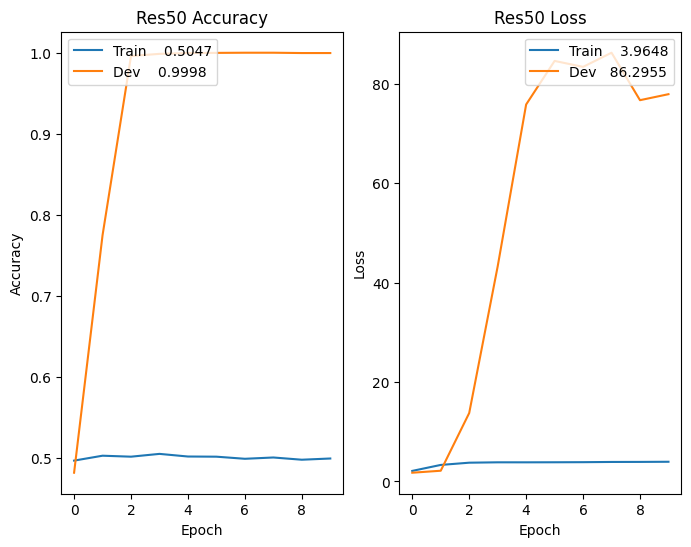

In [ ]:
#%matplotlib inline
plt.style.use( 'default' )  #還原原始設定 (檢查)
plt.figure( figsize=(8,6) )

plt.subplot( 1,2,1 )
# summarize history for accuracy
show_train_history( 'accuracy', 'val_accuracy', 'Res50 Accuracy', 'Accuracy' )#,PICTURE_ACCURACY_FINAL)

plt.subplot( 1,2,2 )
# summarize history for loss 
show_train_history( 'loss', 'val_loss', 'Res50 Loss', 'Loss' )#,PICTURE_ACCURACY_FINAL)

# Test

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [ ]:
model_type = 'own-model' 

if model_type == 'pre-trained':
  model=applications.VGG16(weights="imagenet", include_top=False, input_shape=(WIDTH, HEIGHT, 3))
  print('你使用的是 AI-FreeTeam 的 pre-trained Model')
else:
  model = load_model('/content/model-resnet50-final.h5')
  print('你正在使用自己設計的Model')
model.summary()

你正在使用自己設計的Model
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________

In [ ]:
from google.colab import files
uploaded = files.upload()

from google.colab.patches import cv2_imshow
x = ''
for i in uploaded:
  x = i
predict_img = '/content/test1/' + x
img = load_img(predict_img, target_size=(WIDTH, HEIGHT))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
feature=model.predict(img)
feature = feature.reshape(1,-1)
import cv2
ig = cv2.imread(predict_img,1)
cv2_imshow(ig)

In [ ]:
#預測結果
import pickle
if model_type == 'pre-trained':
  with open('/content/Kaggle_dog-and-cat/clf.pickle', 'rb') as f:
      clf2 = pickle.load(f)
      # predict = model.predict(feature.reshape(1,-1))
      y_pred=clf2.predict(feature)
      # print('模型判斷結果 : ',y_pred)
  if y_pred == 1:
    print('This is a dog.')
  else:
    print('This is a cat.')
else:
  if feature > 0.8:
    print('This is a dog.')
  else:
    print('This is a cat.')

In [ ]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image
import sys
import numpy as np

In [ ]:
# 從參數讀取圖檔路徑
#files = sys.argv[1:]
files = os.listdir('/content/test1')

# 載入訓練好的模型
net = load_model('model-resnet50-final.h5')

cls_list = ['cats', 'dogs']

# 辨識每一張圖
for f in files:
    img = image.load_img(f, target_size=(224, 224))
    if img is None:
        continue
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    pred = net.predict(x)[0]
    top_inds = pred.argsort()[::-1][:5]
    print(f)
    for i in top_inds:
        print('    {:.3f}  {}'.format(pred[i], cls_list[i]))

FileNotFoundError: ignored

# 結果
* VGG16 模型準確率大約為 94%
* ResNet50 模型為基礎，將輸入影像尺寸提高為 224×224，加上大量的 data augmentation，可讓辨識的準確率達到 99%

# 參考資料
* [用簡單的CNN模型訓練模型建立貓貓狗狗辨識程式](https://medium.com/bandai%E7%9A%84%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E7%AD%86%E8%A8%98/%E6%89%8B%E6%8A%8A%E6%89%8B%E7%A8%8B%E5%BC%8F%E5%AF%A6%E4%BD%9C%E5%88%86%E4%BA%AB%E7%B3%BB%E5%88%97-%E7%94%A8%E7%B0%A1%E5%96%AE%E7%9A%84cnn%E6%A8%A1%E5%9E%8B%E8%A8%93%E7%B7%B4%E6%A8%A1%E5%9E%8B%E5%BB%BA%E7%AB%8B%E8%B2%93%E8%B2%93%E7%8B%97%E7%8B%97%E8%BE%A8%E8%AD%98%E7%A8%8B%E5%BC%8F-c290252bad4)
* [Keras 以 ResNet-50 預訓練模型建立狗與貓辨識程式](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)